# Self-Driving Car Engineer Nanodegree


## Advanced Lane Finding Project
The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Apply a distortion correction to raw images.

Use color transforms, gradients, etc., to create a thresholded binary image.

Apply a perspective transform to rectify binary image ("birds-eye view").

Detect lane pixels and fit to find the lane boundary.

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [1]:
#importing some useful packages
#!pip install opencv-python
#!conda install -c conda-forge opencv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

## Compute camera calibration



In [2]:
# Add code for camera calibration here

def calibrate_camera(images_path):
    
    images = glob.glob(images_path)
    
    #define the number of inner corner in both x and y
    nx = 9
    ny = 6
    
    # Arrays to store object ponts and image ponts from all the images
    
    object_points = [] # 3D points in real world space
    image_points = [] # 2D points in image plane space
    
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for image in images:
        #read image into memory
        img = mpimg.imread(image)
        
        #convert to gray scale before applying camera calibration
        # using RGB2GRAY as I used mpimg to read the image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # find corners of chessboard as used in the lessons
        
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        #add result to object_points and image_points if corners were found with sucess
        if ret == True:
            image_points.append(corners)
            object_points.append(objp)
            
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
            cv2.imwrite('images_after_calibration/' + os.path.basename(image), img)
            
    #use open cv calibrate camera function
    # the gray.shape[::-1] means the height and width of the image, as explained in te lesson 6 from camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)
        
    #return mtx and dist only because we only need these parameters to undistort the actual road image
    return mtx, dist
    

## Distortion correction

In [3]:
# Add code for distortion correction here

def undistort_image_computed(image, mtx, dist):
    
    #apply cv2 function undistort with mtx and dist collected from the camera calibration step
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    
    #cv2.imwrite('images_after_undistortion/' + os.path.basename(image_path), dst)
    
    return dst

def undistort_image(image_path, mtx, dist):
    
    image = cv2.imread(image_path)
    
    #apply cv2 function undistort with mtx and dist collected from the camera calibration step
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    
    cv2.imwrite('images_after_undistortion/' + os.path.basename(image_path), dst)
    
    return dst

def undistort_images(images_directory, images_names, mtx, dist):
    
    undistorted_images = []
    
    for img in images_names:
        dst = undistort_image(str(images_directory + img), mtx, dist)
        
        undistorted_images.append(dst)
        
    return undistorted_images
    

## Color and gradient transformation

In [4]:
# Add code for color and gradient transformation here

def get_images_with_hls_channel(images_directory, images_names):
    
    images_with_hls_channel = []
    
    for img in images_names:
        
        image_channels = []
        image = cv2.imread(str(images_directory + img))                 
        hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        h = hls_image[:,:,0]
        l = hls_image[:,:,1]
        s = hls_image[:,:,2]
                           
        image_channels.append(h)
        image_channels.append(l)
        image_channels.append(s)
        cv2.imwrite('images_gradient_h_channel/' + os.path.basename(img), h)
        cv2.imwrite('images_gradient_l_channel/' + os.path.basename(img), l)
        cv2.imwrite('images_gradient_s_channel/' + os.path.basename(img), s)
        
        images_with_hls_channel.append(image_channels)        
        
    return images_with_hls_channel

def extract_s_channel_from_image(image):
    
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s = hls_image[:,:,2]
    return s

def extract_sobel_x_from_image(gray):
        
    # Sobel x as taken from lesson
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def apply_combined_sobelx_and_color_channel_gradient(images_directory, images_names):
    
    channel_processed_images = []
    
    for img in images_names:
        
        image = cv2.imread(str(images_directory + img))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        sxbinary = extract_sobel_x_from_image(gray)
        
        s_channel = extract_s_channel_from_image(image)
        
        # Threshold color channel
        s_thresh_min = 170
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
        height, width = gray.shape
        
        final_region_of_interest_mask = np.zeros_like(combined_binary)
       
        region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
        cv2.fillPoly(final_region_of_interest_mask, [region_of_interest_vertices], 1)
        region_image = cv2.bitwise_and(combined_binary, final_region_of_interest_mask)
        
        cv2.imwrite('images_with_gradients_applied_and_region_of_interest/' + os.path.basename(img), region_image * 255)
        
        channel_processed_images.append(region_image)
        
    return channel_processed_images

def apply_combined_gradient_to_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    sxbinary = extract_sobel_x_from_image(gray)

    s_channel = extract_s_channel_from_image(image)

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    height, width = gray.shape

    final_region_of_interest_mask = np.zeros_like(combined_binary)

    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(final_region_of_interest_mask, [region_of_interest_vertices], 1)
    region_image = cv2.bitwise_and(combined_binary, final_region_of_interest_mask)
    
    return region_image

        

## Perspective transformation

In [5]:
# Add code for perspective transformation here

def warp_images(images, output_folder_path):
    warped_images = []
    minvs = []
    
    for img in images:
        #image = cv2.imread(str(images_directory + img))
        #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        warp_result = warp(img)
        warped_image = warp_result[0]
        Minv = warp_result[2]
        #output_name = str(output_folder_path + img)
        #plt.imshow(warped_image)
        #cv2.imwrite(output_name, warped_image)
        warped_images.append(warped_image)
        minvs.append(Minv)
        
    return warped_images, minvs

def warp(img, src=None, dst=None):

    # Define image size to work with
    img_size = (img.shape[1], img.shape[0])
    
    if src is None:
        src = np.float32(
            [[290,  700],  # Bottom left corner
             [600,  460],  # Top left corner
             [730,  460],  # Top right corner
             [1120, 700]]) # Bottom right corner
        
    if dst is None:
        dst = np.float32(
            [[250,  720],  # Bottom left corner
             [250,    0],  # Top left corner
             [1000,   0],  # Top right corner
             [1000, 720]]) # Bottom right corner 

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the opposite matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linear interpolation as defined in opencv and in the lesson from camera calibration
    warped_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped_image, M, Minv

## Detect lane pixels and fit to find the lane boundary

In [6]:
# Add code for detect lane pixels and fit to find the lane boundary here

def find_all_histograms(images_directory, images_names):
    
    histograms = []
    
    for img in images_names:
        image = mpimg.imread(str(images_directory + img))
        histogram = hist(image)
        #cv2.imwrite('histograms/' + os.path.basename(img), histogram)
        #plt.plot(histogram)
        histograms.append(histogram)
        
    return histograms

#as in the class
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def find_lane_pixels(binary_warped, nwindows = 10, margin = 100, minpix = 50):
    
    histogram = hist(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(binary_warped)
    #cv2.imwrite('sliding_windows_search/' + str(os.path.basename(binary_warped)), out_img)

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, margin = 100):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
   # plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), result

## Determine the curvature of the lane and vehicle position with respect to center

In [7]:
# Add code for determine the curvature of the lane and vehicle position with respect to center here

#this code was taken from the lessons, with some slight changes

def measure_curvature_real(ploty, leftx, rightx, image_shape):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
   # ploty = np.linspace(0, image_shape[0] - 1, image_shape[0])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #print(ploty)
    #print(leftx)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

## Warp the detected lane boundaries back onto the original image

In [8]:
# Add code for warp the detected lane boundaries back onto the original image here

def compose_image_with_lines(img, warped_img, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    #print("Image = " + str(img.shape))
    #print("Warped image = " + str(warped_img.shape))
    #print("Left fit X = " + str(left_fit[0]))
    #print("Right fit X = " + str(right_fit[0]))
    #print("Plot y = " + str(ploty))
    #print("Minv = " + str(Minv))
    
    #plt.imshow(warped_img)
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    
    #one for each color channel
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    #left_fitx = left_fit[0]
    #right_fitx = right_fit[0]

    points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((points_left, points_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([points]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    composed_warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    #plt.imshow(composed_warp)

    weighted_composed_warp = cv2.addWeighted(img, 1, composed_warp, 0.3, 0)
    
    #plt.imshow(weighted_composed_warp)
    return weighted_composed_warp

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [9]:
# Add code for output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position here

def add_image_real_time_info(img, leftx, rightx, ploty, xm_per_pix=3.7/800, ym_per_pix = 25/720):    

    curvature_rads = measure_curvature_real(ploty, leftx, rightx, img.shape)

    offsetx = car_offset(leftx, rightx, img.shape)


    image_with_info = img.copy()
    cv2.putText(image_with_info, 'Left curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(image_with_info, 'Right curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    

    cv2.putText(image_with_info, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return image_with_info

## Project 2 Pipeline 

In [10]:
# Add new pipeline here
imagesDir = os.listdir("test_images/") # get the test images 

original_images = []

for img in imagesDir:
    image = image = cv2.imread(str("test_images/" + img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_images.append(image_rgb)

mtx, dist = calibrate_camera('./camera_cal/calibration*.jpg')

undistorted_images = undistort_images("test_images/", imagesDir, mtx, dist)

images_with_hls_channel = get_images_with_hls_channel("images_after_undistortion/", imagesDir)

channel_processed_images = apply_combined_sobelx_and_color_channel_gradient("images_after_undistortion/", imagesDir)

#original_warped_images = warp_images("test_images/", imagesDir, 'original_warped_images/')

#thresholded_warped_images = warp_images("images_with_gradients_applied_and_region_of_interest/", imagesDir, 'thresholded_warped_images/')
result = warp_images(channel_processed_images, 'thresholded_warped_images/')
thresholded_warped_images = result[0]
minvs = result[1]

histograms = find_all_histograms("thresholded_warped_images/", imagesDir)

sliding_windows_images = []
right_fits = []
left_fits = []
lines_fits_array = []

for i in range(len(histograms)):
    lines_fit, left_points, right_points, out_img = fit_polynomial(thresholded_warped_images[i])
    left_fits.append(left_points)
    right_fits.append(right_points)
    sliding_windows_images.append(out_img)
    lines_fits_array.append(lines_fit)
    
#plt.imshow(sliding_windows_images[2])

optimized_lane_finding = []
left_fits_optimized = []
right_fits_optimized = []
plot_ys = []

for i in range(len(histograms)):
    lines_fit, left_points, right_points, out_img = search_around_poly(thresholded_warped_images[i], lines_fits_array[i][0], lines_fits_array[i][1])
    #result = search_around_poly(thresholded_warped_images[i], left_fits[i], right_fits[i])
    optimized_lane_finding.append(out_img)
    left_fits_optimized.append(left_points)
    right_fits_optimized.append(right_points)
    plot_ys.append(left_points)

#plt.imshow(optimized_lane_finding[2])

composed_images = []

for i in range(len(original_images)):
    composed = compose_image_with_lines(original_images[i], thresholded_warped_images[i], left_fits_optimized[i][0], right_fits_optimized[i][0], left_fits_optimized[i][1], minvs[i])
    composed_images.append(composed)
    
#plt.imshow(composed_images[7])



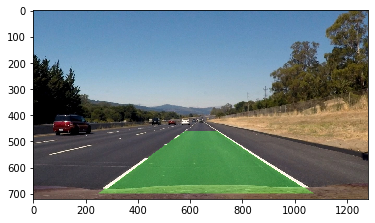

In [59]:
plt.imshow(composed_images[1])

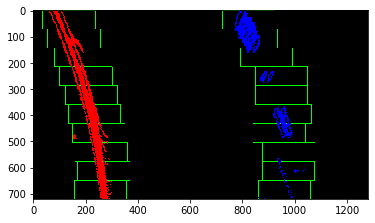

In [22]:
plt.imshow(sliding_windows_images[3])

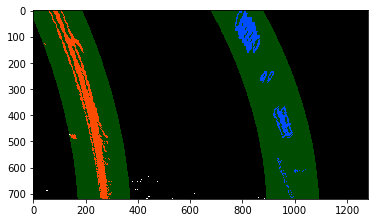

In [23]:
plt.imshow(optimized_lane_finding[3])

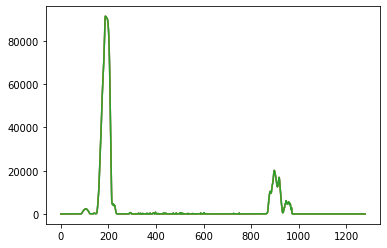

In [11]:
histograms = find_all_histograms("thresholded_warped_images/", imagesDir)

plt.plot(histograms[0])

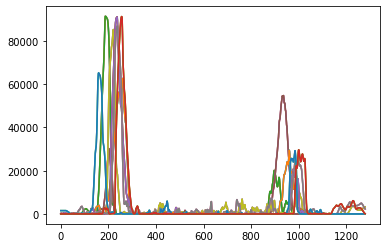

In [12]:
histograms = find_all_histograms("thresholded_warped_images/", imagesDir)

for histogram in histograms:
    plt.plot(histogram)

In [14]:
#printing curvatures for testing purposes

for i in range(len(optimized_lane_finding)):
    #curvatures = measure_curvature_real(plot_ys[i], left_fits[i], right_fits[i], optimized_lane_finding[i].shape)
    
    curvatures = measure_curvature_real(plot_ys[i], left_fits[i], right_fits[i], optimized_lane_finding[i].shape)
    # Print the results
    print('Left line curvature:', curvatures[0], 'm')
    print('Right line curvature:', curvatures[1], 'm')

TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
class Pipeline:
    def __init__(self, cal_path):
        # Make a list of calibration images

        # Calibrate camera
        self.mtx, self.dist = calibrate_camera(cal_path)
        
        self.lines_fit = None

    def __call__(self, img):
        
        # STEP 1: UNDISTORT (using camera calibration step matrix and dist)
        undistorted = undistort_image_computed(img, self.mtx, self.dist)
    
        
        #plt.imshow(undistorted)

        # STEP 3: APPLY COLOR SPACE TRANSFORM AND SOBEL THRESHOLDING
        thresholded = apply_combined_gradient_to_image(undistorted)
        
        #plt.imshow(thresholded)

        # STEP 4: WARP BINARY IMAGE INTO TOP-DOWN VIEW
        warped, M, Minv = warp(thresholded)
        
        #plt.imshow(wad)
        
        lines_fit, left_points, right_points, out_img = fit_polynomial(warped)
        
        lines_fit1, left_points1, right_points1, out_img1 = search_around_poly(warped, lines_fit[0], lines_fit[1])
        
        composed = compose_image_with_lines(img, warped, left_points1[0], right_points1[0], left_points1[1], Minv)
        
        composed_with_info = add_image_real_time_info(composed, left_points1[0], right_points1[0], left_points1[1])
            
        return composed_with_info

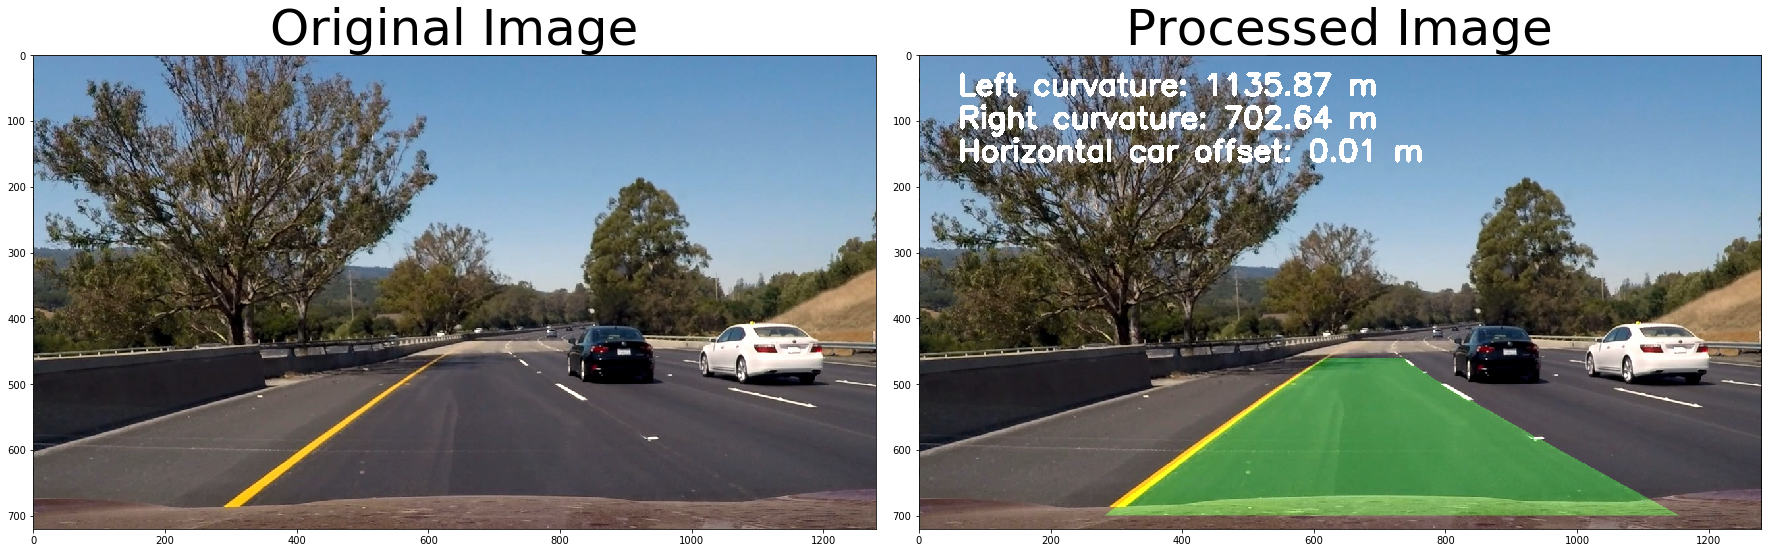

In [16]:
#example of the pipeline applied to 1 single image
img = mpimg.imread('test_images/test6.jpg')

# Process video frames with our 'process_image' function
process_image = Pipeline('./camera_cal/calibration*.jpg')

# Apply pipeline
processed = process_image(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
# Import everything needed to edit/save/watch video clips
#!pip install moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def apply_video(input_video, output_video):

    # Process video frames with our 'process_image' function
    process_image = Pipeline('./camera_cal/calibration*.jpg')
    
    ## You may uncomment the following line for a subclip of the first 5 seconds
    #clip1 = VideoFileClip(input_video).subclip(0,5)
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(output_video, audio=False)

Let's try the one with the solid white lane on the right first ...

In [ ]:
input_video = './harder_challenge_video.mp4'
output_video = './harder_challenge_video_output.mp4'

apply_video(input_video, output_video)

Moviepy - Building video ./harder_challenge_video_output.mp4.
Moviepy - Writing video ./harder_challenge_video_output.mp4



t:  94%|█████████████████████████████████████████████████████████████▍   | 1133/1199 [04:25<00:14,  4.49it/s, now=None]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
input_video = './project_video.mp4'
output_video = './project_video_output.mp4'

apply_video(input_video, output_video)

Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
Wall time: 3min 38s
